# Identify main packages in repositories

In [1]:
import pandas
import matplotlib
import seaborn

import itertools
import sklearn  # Just to check that this library is available now

In [58]:
# To easily change figure size
FIG_SIZE = (6, 3)

In [3]:
%matplotlib inline

matplotlib.rcParams['figure.figsize'] = FIG_SIZE
matplotlib.rcParams['text.latex.preamble'] = [r'\usepackage{amsmath}']

## Load data

In [4]:
df_repo = (
    pandas.read_csv('../data/repositories.csv.gz')
    .assign(first_release_date=lambda d: pandas.to_datetime(d['first_release_date']))
)

df_repo.head()

,Package,Repository_URL,Repository,versions,first_release_date,dependents
0,advapi32-sys,https://github.com/retep998/winapi-rs,winapi-rs,8,2015-01-19 10:26:00,17
1,algebloat,https://github.com/SiegeLord/RustAlgebloat,RustAlgebloat,13,2014-12-16 05:26:00,0
2,algebloat_macros,https://github.com/SiegeLord/RustAlgebloat,RustAlgebloat,13,2014-12-16 05:26:00,1
3,allegro_acodec,https://github.com/SiegeLord/RustAllegro,RustAllegro,31,2014-12-17 16:38:00,1
4,allegro_acodec-sys,https://github.com/SiegeLord/RustAllegro,RustAllegro,29,2015-01-04 02:11:00,1


All repositories in this dataset have more than one package:

[Text(0, 0.5, 'number of repositories'),
 (-0.5, 10),
 Text(0.5, 0, 'number of packages')]

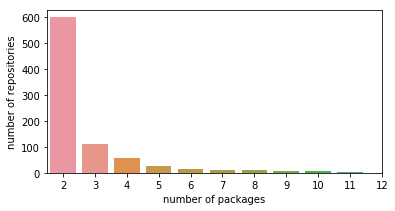

In [5]:
fig, ax = matplotlib.pyplot.subplots()

seaborn.countplot(
    x='Package',
    data=(
        df_repo
        .groupby('Repository_URL')
        [['Package']]
        .count()
    ),
    ax=ax
)

ax.set(
    xlabel='number of packages',
    xlim=(None, 10),
    ylabel='number of repositories',
)

## Transform data

We define several criteria that will be used to identify main packages.
Let's first create two additionnal columns that compare the name of the package with the name of the repository.

In [6]:
df_crit = (
    df_repo
    .assign(exact_name=lambda d: d['Package'].str.lower() == d['Repository'].str.lower())
    .assign(partial_name=lambda d: 
            (d.apply(lambda s: s['Package'].lower() in s['Repository'].lower(), axis=1))
        |   (d.apply(lambda s: s['Repository'].lower() in s['Package'].lower(), axis=1))
    )
)

df_crit.head()

,Package,Repository_URL,Repository,versions,first_release_date,dependents,exact_name,partial_name
0,advapi32-sys,https://github.com/retep998/winapi-rs,winapi-rs,8,2015-01-19 10:26:00,17,False,False
1,algebloat,https://github.com/SiegeLord/RustAlgebloat,RustAlgebloat,13,2014-12-16 05:26:00,0,False,True
2,algebloat_macros,https://github.com/SiegeLord/RustAlgebloat,RustAlgebloat,13,2014-12-16 05:26:00,1,False,False
3,allegro_acodec,https://github.com/SiegeLord/RustAllegro,RustAllegro,31,2014-12-17 16:38:00,1,False,False
4,allegro_acodec-sys,https://github.com/SiegeLord/RustAllegro,RustAllegro,29,2015-01-04 02:11:00,1,False,False


We define several criteria, and we compute their value: a package that is "first" (even with draws) for a criterion will be selected as a "main package" according to that criterion.

In [7]:
criteria = ['exact_name', 'partial_name', 'most_versions', 'first_released', 'most_dependents']

In [8]:
df_crit = (
    df_crit
    .groupby('Repository_URL', sort=False)
    .apply(lambda group:
        group.assign(
            # Create new columns based on existing ones. They are ranked
            # by their value. Draws lead to the same value.
            most_versions=lambda d: (d['versions'].rank(method='min', ascending=False) == 1),
            first_released=lambda d: (d['first_release_date'].rank(method='min') == 1),
            most_dependents=lambda d: (d['dependents'].rank(method='min', ascending=False) == 1),
        )
    )
    # Clean dataframe structure
    .reset_index(drop=True)
    [['Package', 'Repository_URL'] + criteria]
)

In [9]:
df_crit.head(10)

,Package,Repository_URL,exact_name,partial_name,most_versions,first_released,most_dependents
0,advapi32-sys,https://github.com/retep998/winapi-rs,False,False,False,False,False
1,gdi32-sys,https://github.com/retep998/winapi-rs,False,False,False,False,False
2,kernel32-sys,https://github.com/retep998/winapi-rs,False,False,False,False,False
3,ole32-sys,https://github.com/retep998/winapi-rs,False,False,False,False,False
4,shell32-sys,https://github.com/retep998/winapi-rs,False,False,False,False,False
5,user32-sys,https://github.com/retep998/winapi-rs,False,False,False,False,False
6,winapi,https://github.com/retep998/winapi-rs,False,True,True,True,True
7,winmm-sys,https://github.com/retep998/winapi-rs,False,False,False,False,False
8,activeds-sys,https://github.com/retep998/winapi-rs,False,False,False,False,False
9,aclui-sys,https://github.com/retep998/winapi-rs,False,False,False,False,False


We now rely on those criterion to identify main packages (they are not necessarily unique) for each repository.

In [10]:
df_crit = (
    df_crit
    .assign(criteria=lambda d: d[criteria].sum(axis=1))
    .groupby('Repository_URL', sort=False)
    .apply(lambda group: 
        group.assign(
            main=lambda d: (d['criteria'].rank(method='min', ascending=False) == 1),
        )
    )
    .reset_index(drop=True)
)

In [11]:
# This random_state incidentaly selects interesting examples
df_crit.sample(5, random_state=12345)

,Package,Repository_URL,exact_name,partial_name,most_versions,first_released,most_dependents,criteria,main
469,cssparser-macros,https://github.com/servo/rust-cssparser,False,False,False,False,False,0,False
2391,rocket,https://github.com/SergioBenitez/Rocket,True,True,True,True,True,5,True
1523,tweetnacl-sys,https://github.com/jmesmon/sodalite,False,False,False,False,True,1,False
2846,hyper-zipkin,https://github.com/palantir/rust-zipkin,False,False,False,False,False,0,False
2669,enum-kinds-traits,https://bitbucket.org/Soft/enum-kinds,False,True,False,True,True,3,False


## Main packages are not unique

Main packages are not unique. Because a package is tagged as "main" if it has the highest score, we could have draws. 
We look at how many repositories have more than one "main" package.

[Text(0, 0.5, 'number of repositories'),
 Text(0.5, 0, 'number of main packages')]

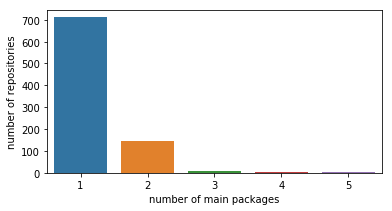

In [63]:
fig, ax = matplotlib.pyplot.subplots()

seaborn.countplot(
    x='Package',
    data=(
        df_crit
        .query('main')
        .groupby('Repository_URL', sort=False)
        [['Package']]
        .count()
    ), 
    ax=ax,
)

ax.set(
    xlabel='number of main packages',
    ylabel='number of repositories',
    #yscale='log',
)

One of the reason why repositories can have more than one package is because the "score" of these packages could be quite low, leading to more "draws". Let's check this hypothesis.

[Text(0, 0.5, 'number of repositories'),
 Text(0.5, 0, '"score" of of main packages')]

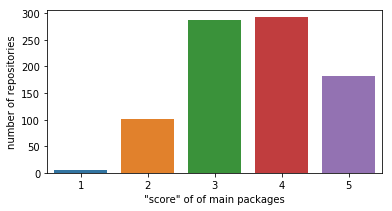

In [64]:
fig, ax = matplotlib.pyplot.subplots()

seaborn.countplot(
    x='criteria',
    data=(
        df_crit
        .query('main')
        .drop_duplicates(['Repository_URL', 'criteria'])
    ), 
    ax=ax,
)

ax.set(
    xlabel='"score" of of main packages',
    ylabel='number of repositories',
    #yscale='log',
)

Let's now check what is the score in case of "draws". 

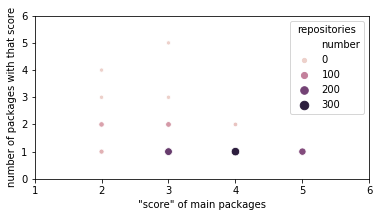

In [57]:
fig, ax = matplotlib.pyplot.subplots()

seaborn.scatterplot(
    x='criteria',
    y='Package', 
    size='number',
    hue='number',
    data=(
        df_crit
        .query('main')
        .groupby('Repository_URL', sort=False)
        .agg({'Package': 'count', 'criteria': 'max'})
        .assign(number=1)
        .groupby(['Package', 'criteria'], sort=False)
        .agg({'Package': 'first', 'criteria': 'first', 'number': 'count'})
        .reset_index(drop=True)
    ),
    ax=ax,
)

ax.set(
    xlabel='"score" of main packages',
    xlim=(1, 6),
    ylabel='number of packages with that score',
    ylim=(0, 6),
)

ax.legend(title='repositories')

This suggests that most "non-draws" have a score of 3 to 5, while most draws have a score of 2 or 3. 

## Criteria agreement

How many times each criterion leads to the same "answer" than "main"?

In [12]:
(
    df_crit
    .assign(**{
        # Use a double lambda to fix "c" in the closure of inner lambda
        c: (lambda c: (lambda d: d[c] == d['main']))(c) for c in criteria
    })
    [criteria]
    .pipe(lambda d: d.sum() / len(d))
)

exact_name         0.798268
partial_name       0.668110
most_versions      0.832323
first_released     0.866089
most_dependents    0.817893
dtype: float64

Obviously, not all cases are of interest. For instance, we would like to favour criteria that can be used to identify main packages, not criteria that can be used to identify non-main packages. We therefore compute the confusion matrix for each criterion.

In [13]:
# We do that in a loop because it's easier to write and we don't have that many data, so we can skip pandas' features this time ;-)
matrices = {
    c: dict(TP=0, FP=0, TN=0, FN=0)
    for c in criteria
}

for row in df_crit.itertuples():
    for criterion in criteria:
        if getattr(row, 'main'):
            if getattr(row, criterion):
                matrices[criterion]['TP'] += 1
            else:
                matrices[criterion]['FN'] += 1
        else:
            if getattr(row, criterion):
                matrices[criterion]['FP'] += 1
            else:
                matrices[criterion]['TN'] += 1

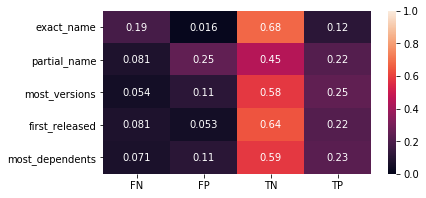

In [14]:
fig, ax = matplotlib.pyplot.subplots()

seaborn.heatmap(
    data=pandas.DataFrame(matrices).T / len(df_crit),
    vmin=0, 
    vmax=1,
    annot=True,
    ax=ax
)


As this plot is not very useful, let's compute precision and recall for each criterion.
We also compute other metrics "just in case". 
Notice that "accuracy" is not very reliable here, because the classes are imbalanced.

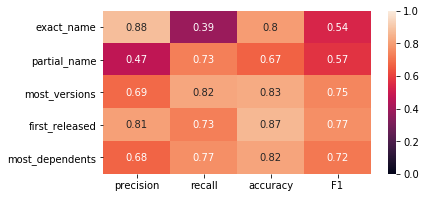

In [15]:
fig, ax = matplotlib.pyplot.subplots()

seaborn.heatmap(
    data=(
        pandas.DataFrame(matrices)
        .T
        # Using eval to make it more readable and to we avoid the use of, e.g., d['TP'] + (d['TP'] + d['FP'])
        .eval('precision = TP / (TP + FP)')
        .eval('recall = TP / (TP + FN)')
        .eval('accuracy = (TP + TN) / (TP + TN + FP + FN)')
        .eval('F1 = 2 * TP / (2 * TP + FP + FN)')
        [['precision', 'recall', 'accuracy', 'F1']]
    ),
    vmin=0, 
    vmax=1,
    annot=True,
    ax=ax
)

## Combinations of criteria

We look for combinations of criteria that could improve these scores. 

At first, we see pairwise correlations between them, to get a better idea of the possible redundancy.

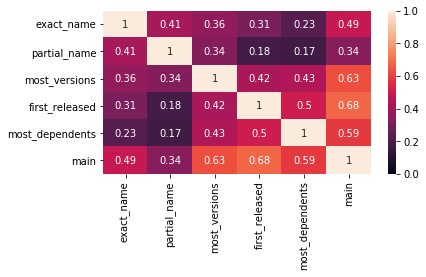

In [16]:
fig, ax = matplotlib.pyplot.subplots()

seaborn.heatmap(
    data=(
        df_crit
        [criteria + ['main']]
        .corr()
    ),
    vmin=0, 
    vmax=1,
    annot=True,
    ax=ax,
)

Let's create some decision trees to see what could be the set of useful criteria. We should be careful because classes are imbalanced! 

In [17]:
df_crit['main'].value_counts()

False    2416
True     1049
Name: main, dtype: int64

Let's balance classes:

In [18]:
from sklearn.utils import resample

df_balanced = pandas.concat([
    # First the "non-main packages" (majority)
    # Here query() is more readable than df_crit[~df_crit['main']]
    # or even than df_crit[lambda d: ~d['main']]
    df_crit.query('not main'),
    
    # Then we augment the minority class
    resample(
        df_crit.query('main'), 
        replace=True, 
        n_samples=len(df_crit.query('not main')),
        random_state=12345,
    )
])

df_balanced['main'].value_counts()

True     2416
False    2416
Name: main, dtype: int64

To avoid our models to overfit the data, we rely on a split validation. We avoid k-fold cross-validation at this point of the analysis because (1) it leads to k models, making the overall model more difficult to interpret and (2) it requires aggregating scores which could hide some interesting things at this point. The k-fold cross-validation will be performed later.

In [19]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(
    df_balanced[criteria], 
    df_balanced['main'], 
    test_size=0.5, 
    random_state=12345  # For reproductibility purpose
)

In [20]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import recall_score, precision_score, accuracy_score, f1_score

scores = {
    'recall': recall_score,
    'precision': precision_score,
    'accuracy': accuracy_score,
    'f1_score': f1_score,
}

We create a first tree based on all critera, just to have an idea on "how good" (or "how bad") it is.

In [21]:
tree = DecisionTreeClassifier()
tree.fit(x_train, y_train)

y_pred = tree.predict(x_test)

for label, fun in scores.items():
    score = fun(y_test, y_pred)
    print(label, score)

recall 0.9299258037922506
precision 0.8959491660047657
accuracy 0.9105960264900662
f1_score 0.912621359223301


Let's have a look at the features:

In [22]:
pandas.DataFrame(index=criteria, data=tree.feature_importances_)

,0
exact_name,0.068821
partial_name,0.009416
most_versions,0.234650
first_released,0.635406
most_dependents,0.051706


It seems that not all features are equally important. We already spotted this from the correlation analysis we made earlier.

Let's try a naive approach in which we compute all possible combinations of features. 

In [23]:
# Recipe taken from https://docs.python.org/3/library/itertools.html
combinations = list(itertools.chain.from_iterable(itertools.combinations(criteria, r) for r in range(len(criteria)+1)))[1:]

In [24]:
results = pandas.DataFrame(index=combinations, columns=scores.keys())

for combination in combinations: 
    x_train, x_test, y_train, y_test = train_test_split(
        df_balanced[list(combination)], 
        df_balanced['main'], 
        test_size=0.5, 
        random_state=12345  # For reproductibility purpose
    )
    tree = DecisionTreeClassifier()
    tree.fit(x_train, y_train)
    
    # Evaluate model
    y_pred = tree.predict(x_test)

    for label, fun in scores.items():
        score = fun(y_test, y_pred)
        results.at[combination, label] = score

In [25]:
# The following cell contains too many information, we will filter this later.
results

,recall,precision,accuracy,f1_score
"(exact_name,)",0.36521,0.944563,0.67053,0.526754
"(partial_name,)",0.713932,0.669243,0.679222,0.690866
"(most_versions,)",0.826051,0.828099,0.826573,0.827074
"(first_released,)",0.743611,0.905622,0.832368,0.816659
"(most_dependents,)",0.76587,0.824312,0.800497,0.794017
"(exact_name, partial_name)",0.36521,0.944563,0.67053,0.526754
"(exact_name, most_versions)",0.873042,0.827991,0.845199,0.84992
"(exact_name, first_released)",0.843364,0.895013,0.871689,0.868421
"(exact_name, most_dependents)",0.881286,0.829969,0.849752,0.854858
"(partial_name, most_versions)",0.826051,0.828099,0.826573,0.827074


In [26]:
# We compute ranks to ease identifying the "best" combinations
(
    results
    .assign(**{
        '{}_rank'.format(c): (lambda c: (lambda d: d[c].rank(method='min', ascending=False)))(c)
        for c in scores.keys()
    })
    .sort_values('f1_score_rank')
    .head(10)
)

,recall,precision,accuracy,f1_score,recall_rank,precision_rank,accuracy_rank,f1_score_rank
"(exact_name, partial_name, most_versions, first_released, most_dependents)",0.929926,0.895949,0.910596,0.912621,7.0,7.0,1.0,1.0
"(exact_name, most_versions, first_released, most_dependents)",0.929926,0.895949,0.910596,0.912621,7.0,7.0,1.0,1.0
"(partial_name, most_versions, first_released, most_dependents)",0.95878,0.850146,0.894454,0.901201,4.0,16.0,3.0,3.0
"(exact_name, partial_name, first_released, most_dependents)",0.926628,0.863287,0.889487,0.893837,9.0,13.0,4.0,4.0
"(exact_name, partial_name, most_versions, first_released)",0.935697,0.852102,0.886175,0.891945,5.0,14.0,5.0,5.0
"(partial_name, most_versions, first_released)",0.935697,0.852102,0.886175,0.891945,5.0,14.0,5.0,5.0
"(most_versions, first_released)",0.967848,0.80854,0.868791,0.881051,3.0,28.0,13.0,7.0
"(most_versions, first_released, most_dependents)",0.857378,0.902778,0.882036,0.879493,18.0,6.0,7.0,8.0
"(partial_name, first_released, most_dependents)",0.878813,0.871627,0.874172,0.875205,15.0,12.0,8.0,9.0
"(exact_name, most_versions, most_dependents)",0.987634,0.77641,0.850993,0.869376,1.0,30.0,14.0,10.0


At this point, it looks like "most_versions" and "first_released" is the smallest subset of criteria that still provides very good results.

Because sklearn has a "feature ranking with recursive feature elimination" utility, we could achieve the same process using it. Also, I've just discovered this, so I want to play a little bit with it ;-)

In [27]:
from sklearn.feature_selection import RFE

results = pandas.DataFrame(index=range(1, len(criteria) + 1), columns=['features'] + list(scores.keys()))

x_train, x_test, y_train, y_test = train_test_split(
    df_balanced[criteria], 
    df_balanced['main'], 
    test_size=0.5, 
    random_state=12345  # For reproductibility purpose
)

for n_features in range(1, len(criteria) + 1):
    selector = RFE(DecisionTreeClassifier(), n_features)
    selector.fit(x_train, y_train)
    
    # Identify features
    results.at[n_features, 'features'] = pandas.np.extract(selector.support_, criteria)
    
    # Evaluate model
    y_pred = selector.predict(x_test)

    for label, fun in scores.items():
        score = fun(y_test, y_pred)
        results.at[n_features, label] = score

In [28]:
results

,features,recall,precision,accuracy,f1_score
1,[first_released],0.743611,0.905622,0.832368,0.816659
2,"[most_versions, first_released]",0.967848,0.80854,0.868791,0.881051
3,"[exact_name, most_versions, first_released]",0.833471,0.903485,0.871689,0.867067
4,"[exact_name, most_versions, first_released, mo...",0.929926,0.895949,0.910596,0.912621
5,"[exact_name, partial_name, most_versions, firs...",0.929926,0.895949,0.910596,0.912621


Again, we observe that "most_versions" + "first_released" is a good combination. Remember that because of the way RFE works, each proposed combination is the best one among the ones of the same size. In this case, that means that "first_released" is the best attribute to use if only a single one has to be chosen. We also observe that there's no difference between 4 features and 5 features (this implies that "partial_name", the one that's missing for 4 features, is totaly redundant with the four other features). 